## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_response = pd.read_csv('drive/My Drive/Retail_Data_Response.csv')
df_transactions = pd.read_csv('drive/My Drive/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [7]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [8]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated
# เลือกข้อมูลแค่ 2 ปีเนื่องจากข้อมูลที่เก็บเป็นเวลานานอาจจะทำให้การวิเคราะห์คาดเคลื่อน

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']= df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions['year'] = df_transactions['trans_date'].dt.strftime('%Y')
df_transactions['month'] = df_transactions['trans_date'].dt.strftime('%m')
df_transactions = df_transactions[(df_transactions['year'] >= '2013')]
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,year,month
0,CS5295,2013-02-11,35,764.0,2013,02
1,CS4768,2015-03-15,39,2.0,2015,03
2,CS2122,2013-02-26,52,749.0,2013,02
4,CS1850,2013-11-20,78,482.0,2013,11
5,CS5539,2014-03-26,81,356.0,2014,03


In [9]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency ล่าสุด
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum() ,                # Monetary Value
                                                     'trans_date' : lambda x: (x.max() - x.min()).days 
                                                     }) 

df_rfm.rename(columns={'recent': 'recency', 
                      'customer_id': 'frequency', 
                      'tran_amount': 'monetary_value',
                      'trans_date' : 'aou'}, inplace=True)

df_rfm["ticketsize"] = df_rfm['monetary_value']/df_rfm['frequency']

In [10]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,aou,ticketsize
0,CS1112,62.0,7,463,684,66.142857
1,CS1113,36.0,12,872,705,72.666667
2,CS1114,33.0,12,856,756,71.333333
3,CS1115,12.0,12,925,775,77.083333
4,CS1116,204.0,6,392,598,65.333333


## **Calculating response rate**

In [11]:
# 0 = non response , 1 = response 
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


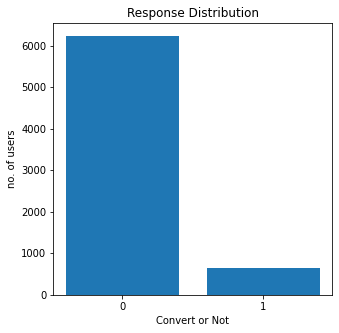

In [12]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [13]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,aou,ticketsize
0,CS1112,0,62.0,7,463,684,66.142857
1,CS1113,0,36.0,12,872,705,72.666667
2,CS1114,1,33.0,12,856,756,71.333333
3,CS1115,1,12.0,12,925,775,77.083333
4,CS1116,1,204.0,6,392,598,65.333333


## **Creating train and test dataset**

In [14]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 5)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 5)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

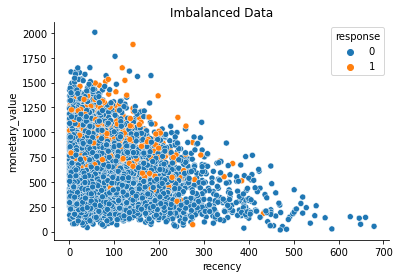

In [16]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

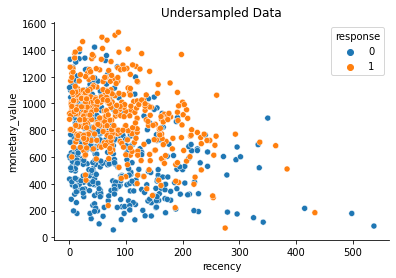

In [17]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value','aou','ticket_size' , 'response' ]

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

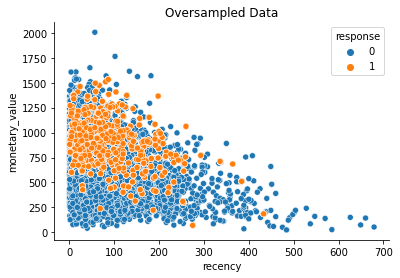

In [18]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value','aou' , 'ticket_size','response']
sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

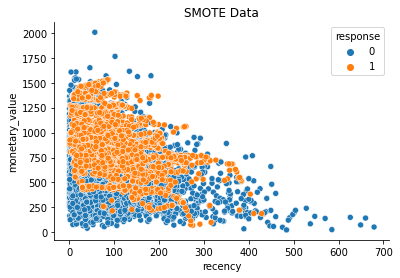

In [19]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value','aou','ticket_size', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [20]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       429
           1       0.70      0.75      0.72       429

    accuracy                           0.71       858
   macro avg       0.71      0.71      0.71       858
weighted avg       0.71      0.71      0.71       858

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.22      0.77      0.34       218

    accuracy                           0.68      2066
   macro avg       0.59      0.72      0.56      2066
weighted avg       0.88      0.68      0.74      2066



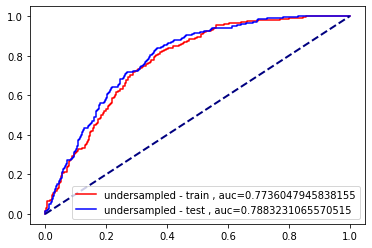

In [21]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [22]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00184888  0.13796498  0.00257556 -0.00437301  0.01252598]] [-1.74712755]


In [23]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.70      0.74      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.22      0.77      0.34       218

    accuracy                           0.68      2066
   macro avg       0.59      0.72      0.56      2066
weighted avg       0.88      0.68      0.74      2066



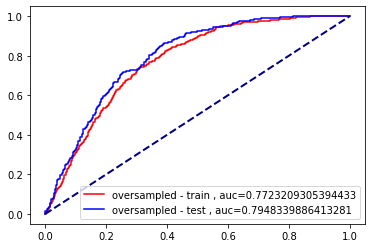

In [24]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [25]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 2.80338730e-03  3.19474027e-01 -9.93087411e-05 -3.87268290e-03
   3.47943302e-02]] [-1.74712755]


In [26]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.71      0.74      0.72      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.79      1848
           1       0.21      0.73      0.33       218

    accuracy                           0.69      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.69      0.75      2066



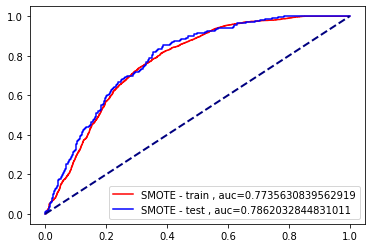

In [27]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [28]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.00159732  0.00064516  0.00477093 -0.00427964 -0.01593001]] [-1.74712755]


## **XGBoost**



In [29]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.769065
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.771327
[2]	validation_0-auc:0.771963
[3]	validation_0-auc:0.775259
[4]	validation_0-auc:0.779342
[5]	validation_0-auc:0.782482
[6]	validation_0-auc:0.784735
[7]	validation_0-auc:0.785078
[8]	validation_0-auc:0.786605
[9]	validation_0-auc:0.788816
[10]	validation_0-auc:0.790596
[11]	validation_0-auc:0.791392
[12]	validation_0-auc:0.792503
[13]	validation_0-auc:0.793665
[14]	validation_0-auc:0.793077
[15]	validation_0-auc:0.791272
[16]	validation_0-auc:0.791947
[17]	validation_0-auc:0.792741
[18]	validation_0-auc:0.792902
Stopping. Best iteration:
[13]	validation_0-auc:0.793665

training set
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       429
           1       0.70      0.83      0.76       429

    accuracy                           0.73       858
   macro avg       0.74      0.73      0

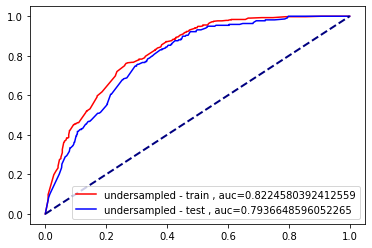

In [30]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

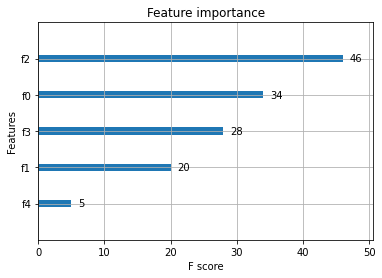

In [31]:
xgb.plot_importance(xgb_model_under)

In [32]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.775429
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.788259
[2]	validation_0-auc:0.784711
[3]	validation_0-auc:0.785591
[4]	validation_0-auc:0.793413
[5]	validation_0-auc:0.795129
[6]	validation_0-auc:0.795484
[7]	validation_0-auc:0.796663
[8]	validation_0-auc:0.797614
[9]	validation_0-auc:0.797367
[10]	validation_0-auc:0.797489
[11]	validation_0-auc:0.797339
[12]	validation_0-auc:0.796336
[13]	validation_0-auc:0.797463
Stopping. Best iteration:
[8]	validation_0-auc:0.797614

training set
              precision    recall  f1-score   support

           0       0.78      0.66      0.71      4389
           1       0.70      0.81      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.74      0.73      0.73      8778
weighted avg       0.74      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.97 

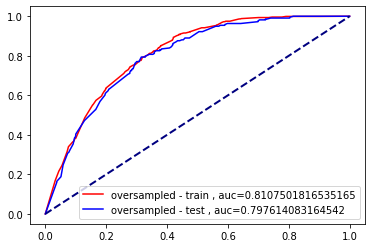

In [33]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

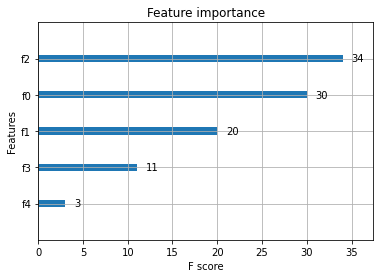

In [34]:
xgb.plot_importance(xgb_model_over)

In [35]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.751695
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.756155
[2]	validation_0-auc:0.776531
[3]	validation_0-auc:0.78835
[4]	validation_0-auc:0.784771
[5]	validation_0-auc:0.783838
[6]	validation_0-auc:0.786489
[7]	validation_0-auc:0.792719
[8]	validation_0-auc:0.790749
[9]	validation_0-auc:0.792333
[10]	validation_0-auc:0.795343
[11]	validation_0-auc:0.795509
[12]	validation_0-auc:0.794635
[13]	validation_0-auc:0.794213
[14]	validation_0-auc:0.796295
[15]	validation_0-auc:0.797228
[16]	validation_0-auc:0.797174
[17]	validation_0-auc:0.795786
[18]	validation_0-auc:0.794891
[19]	validation_0-auc:0.794494
[20]	validation_0-auc:0.794511
Stopping. Best iteration:
[15]	validation_0-auc:0.797228

training set
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      4389
           1       0.73      0.87      0.79      4389

    accuracy                           0

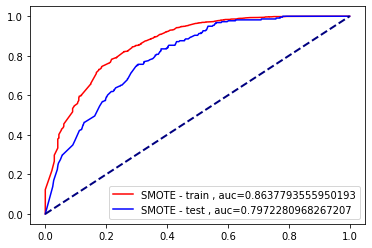

In [36]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

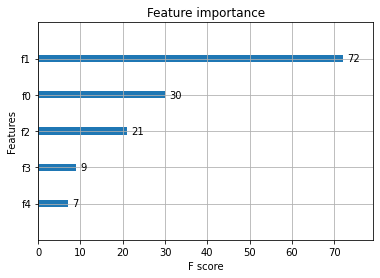

In [37]:
xgb.plot_importance(xgb_model_SMOTE)

In [38]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.760968
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.763519
[2]	validation_0-auc:0.778922
[3]	validation_0-auc:0.768933
[4]	validation_0-auc:0.770646
[5]	validation_0-auc:0.758312
[6]	validation_0-auc:0.768522
[7]	validation_0-auc:0.768537
Stopping. Best iteration:
[2]	validation_0-auc:0.778922

training set
              precision    recall  f1-score   support

           0       0.85      0.61      0.71      4389
           1       0.69      0.89      0.78      4389

    accuracy                           0.75      8778
   macro avg       0.77      0.75      0.74      8778
weighted avg       0.77      0.75      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1848
           1       0.19      0.80      0.31       218

    accuracy                           0.63      2066
   macro avg       0.58      0.7

##Decision Tree##

In [39]:
#Decision Tree for Undersampled
print('decision tree model - undersampled')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_under = decision_tree.fit(X_undersampled, y_undersampled)
predictions = decision_tree_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

decision tree model - undersampled
training set
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       429
           1       0.72      0.78      0.75       429

    accuracy                           0.73       858
   macro avg       0.74      0.73      0.73       858
weighted avg       0.74      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.21      0.77      0.33       218

    accuracy                           0.68      2066
   macro avg       0.59      0.72      0.56      2066
weighted avg       0.88      0.68      0.74      2066



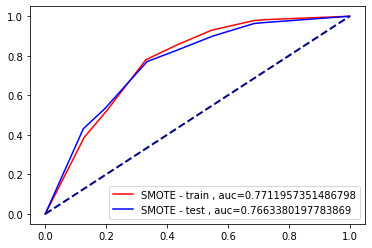

In [40]:
y_score_train = decision_tree_under.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [41]:
#Decision Tree for Oversampled
print('decision tree model - oversampled')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_over = decision_tree.fit(X_oversampled, y_oversampled)
predictions = decision_tree_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

decision tree model - oversampled
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.71      0.75      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.76      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.72      0.57      2066
weighted avg       0.88      0.69      0.75      2066



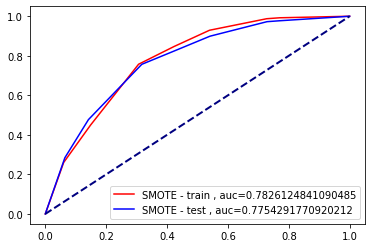

In [42]:
y_score_train = decision_tree_over.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [43]:
#Decision Tree for SMOTE
print('decision tree model - SMOTE')

predicted_y = []
expected_y = []

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree_SMOTE = decision_tree.fit(X_SMOTE, y_oversampled)
predictions = decision_tree_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = decision_tree_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

decision tree model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.86      0.55      0.67      4389
           1       0.67      0.91      0.77      4389

    accuracy                           0.73      8778
   macro avg       0.77      0.73      0.72      8778
weighted avg       0.77      0.73      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      1848
           1       0.18      0.85      0.30       218

    accuracy                           0.58      2066
   macro avg       0.57      0.70      0.50      2066
weighted avg       0.89      0.58      0.66      2066



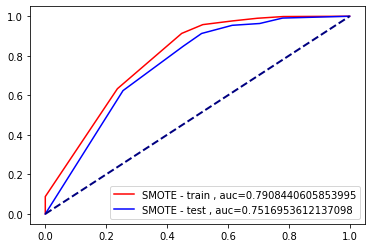

In [44]:
y_score_train = decision_tree_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = decision_tree_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()